### Step 1
Initialize Spark Session

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql import functions as F
from pyspark.sql.types import *

spark = SparkSession \
    .builder \
    .appName("Clickstream Analysis in Spark") \
    .getOrCreate()


### Step 2
Connection to Kafka Producer/Broker and subscribe to the topic and load data from Kafka topic with <code>readStream</code>

In [2]:
#configuration
hostip = "10.156.3.124" #change me

topic = "clickstream"
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", f'{hostip}:9092') \
    .option("subscribe", topic) \
    .load()

In [3]:
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



### Step 3 
Converting the key/value from the kafka data stream to string

In [4]:
df = df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

See the output in the console to examine the data after casting to string

In [5]:
query = df \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .trigger(processingTime='5 seconds') \
    .start()

In [6]:
query.stop()

In [7]:
df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: string (nullable = true)



### Step 4
Define a schema according to our data (as sent from the producer), Use <code>from_json</code> to parse the string to the json format based on the defined schema.
Depending on how you are sending the data, you can define a DataFrame Schema on the receiver's side. For example if you are sending a json list from the producer with "Clicks", "Impressions" and "ts" fields, you can define a schema as follows

In [8]:
schema = StructType([    
    StructField('Clicks', IntegerType(), True), 
    StructField('Impressions', IntegerType(), True),
    StructField('ts', TimestampType(), True)            
])

In [9]:
df=df.select(F.from_json(F.col("value").cast("string"), schema).alias('parsed_value'))

In [10]:
df.printSchema()

root
 |-- parsed_value: struct (nullable = true)
 |    |-- Clicks: integer (nullable = true)
 |    |-- Impressions: integer (nullable = true)
 |    |-- ts: timestamp (nullable = true)



In [11]:
df.printSchema()

root
 |-- parsed_value: struct (nullable = true)
 |    |-- Clicks: integer (nullable = true)
 |    |-- Impressions: integer (nullable = true)
 |    |-- ts: timestamp (nullable = true)



The columns need to be renamed appropriately.

In [12]:
df_formatted = df.select(
                    F.col("parsed_value.Clicks").alias("Clicks"),
                    F.col("parsed_value.Impressions").alias("Impressions"),
                    F.col("parsed_value.ts").alias("ts")
                )

In [13]:
df_formatted.printSchema()

root
 |-- Clicks: integer (nullable = true)
 |-- Impressions: integer (nullable = true)
 |-- ts: timestamp (nullable = true)



### Step 5
Create the <strong>output sink</strong> for the stream. 
Click on the following links to learn more about the relevant topics.
<table>
<tr><td><b>Output Modes</b></td><td><a href="https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#output-modes" target="_blank">Link</a></td></tr>
    <tr><td><b>Output Sinks</b></td><td><a href="https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#output-sinks" target="_blank">Link</a></td></tr>
        <tr><td><b>Triggers</b></td><td><a href="https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#triggers" target="_blank">Link</a></td></tr>
</table>

In [14]:
query = df_formatted \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .trigger(processingTime='5 seconds') \
    .start()

<strong>Stopping the query</strong>

In [15]:
query.stop()

### Operations on streaming DataFrames <a href="https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#operations-on-streaming-dataframesdatasets" target="_blank">[Ref]</a>
You can apply all kinds of operations on streaming DataFrames/Datasets – ranging from untyped, SQL-like operations (e.g. select, where, groupBy), to typed RDD-like operations (e.g. map, filter, flatMap).

The data we have been recieving has "clicks", "impressions" and "timestamps". We now would like to group the total number of impressions for each minute. We can apply this transformation to the readstream query before writing it to the output sink.

In [16]:
#Using the .minute function, we can perform the following aggregation 
grouped_by_min = df_formatted.groupBy(F.minute("ts").alias("minute_bin"))\
                    .agg(F.sum("Impressions").alias("Total Impressions"))            

In [17]:
grouped_by_min.printSchema()

root
 |-- minute_bin: integer (nullable = true)
 |-- Total Impressions: long (nullable = true)



In [18]:
query = grouped_by_min \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .trigger(processingTime='5 seconds') \
    .start()

In [19]:
#stop the running query first
query.stop()

### Visualizing streaming data 
We have implemented the aggregation to get number of impressions every minute. Let's write this this to the memory sink and query it using spark sql for visualizing it in real time.

Note that, since we are using "aggregated query", we need use "complete" as the output mode.

<strong>You can see the output every 5 seconds in the console as well</strong>

In [20]:
#Change the output sink to "memory" and write output to the memory sink
query = grouped_by_min \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("impressions_minute_bin") \
    .trigger(processingTime='5 seconds') \
    .start()

In [21]:
spark.sql("select * from impressions_minute_bin").show()

+----------+-----------------+
|minute_bin|Total Impressions|
+----------+-----------------+
+----------+-----------------+



Here, first we need to initialize an empty plot.

In [22]:
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')        
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


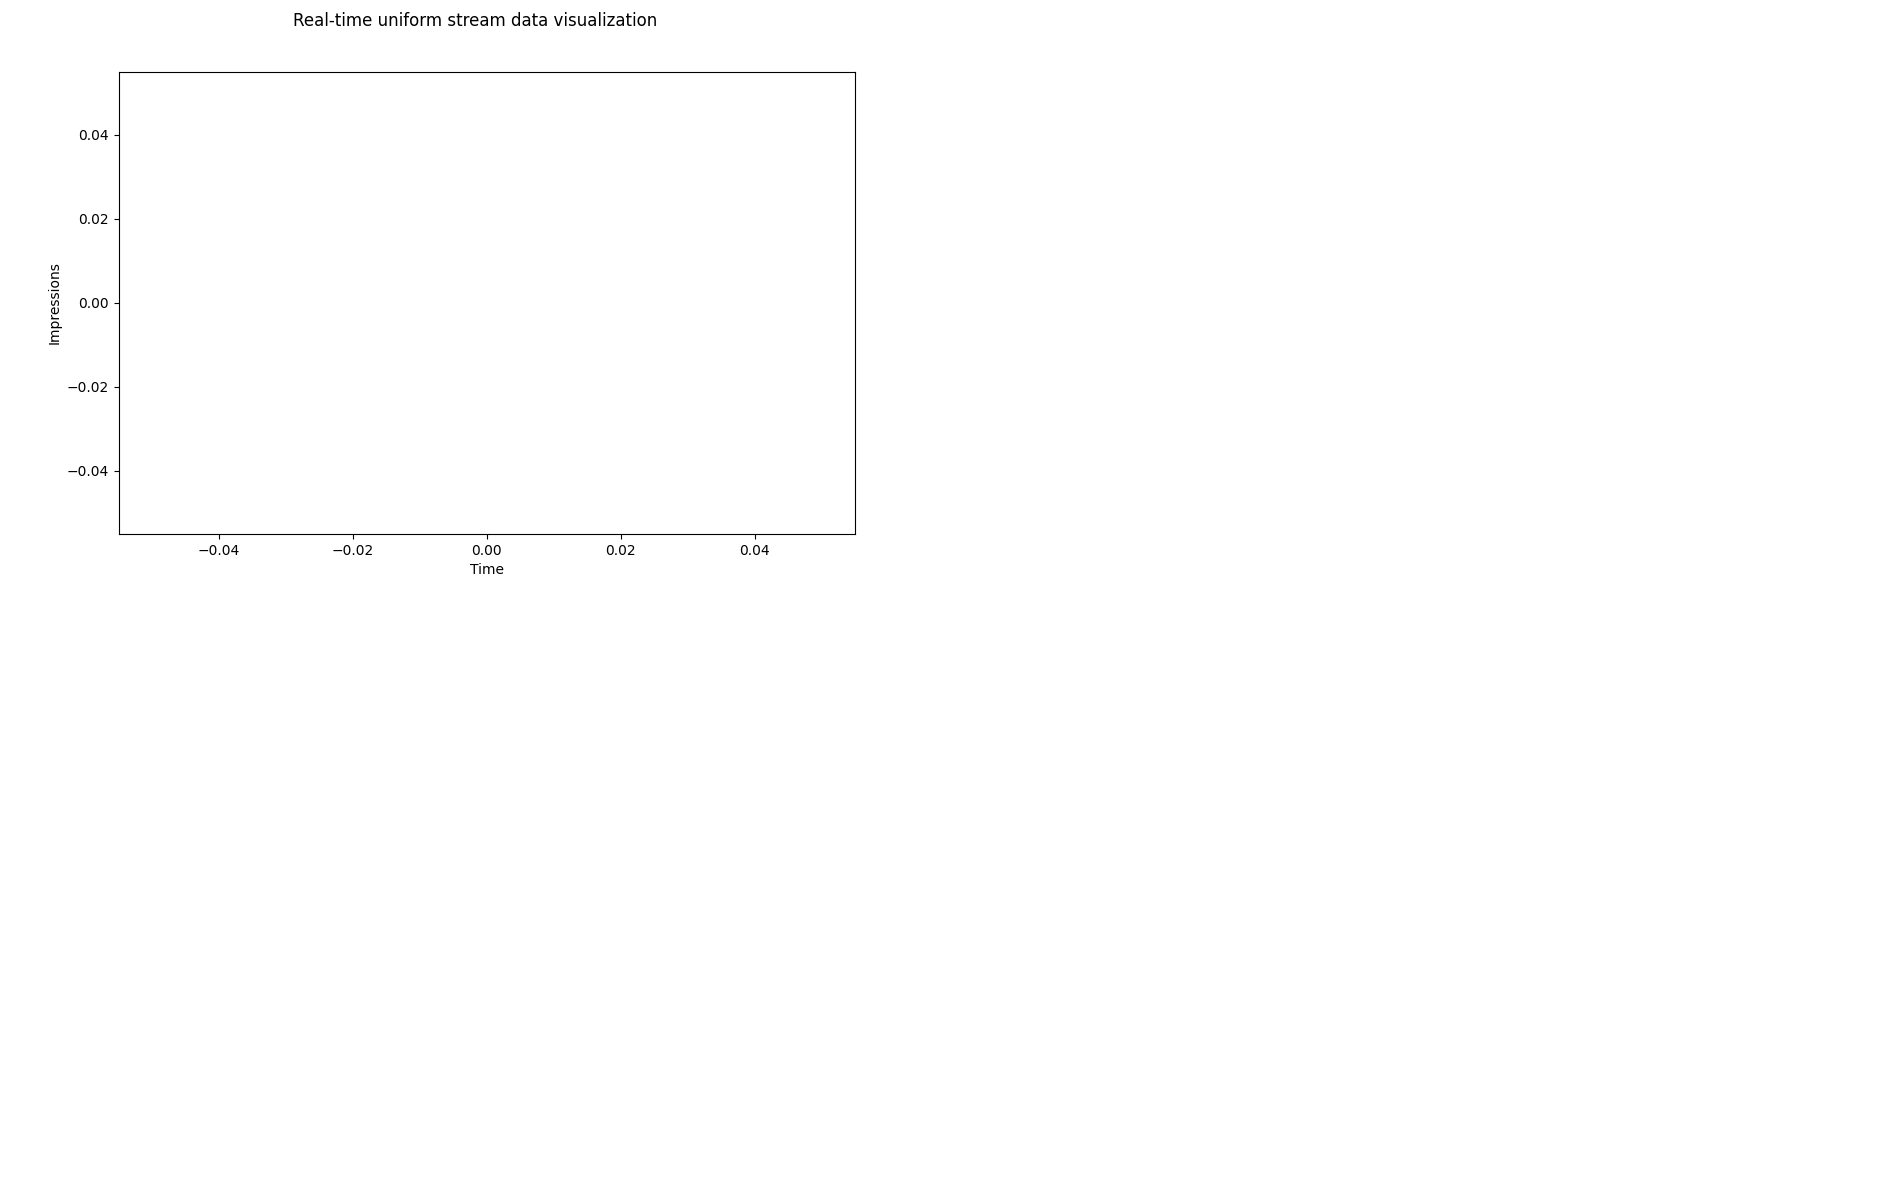

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan

[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan

In [ ]:
import time
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = init_plots()

while True:
    df = spark.sql("select * from impressions_minute_bin order by minute_bin desc limit 10").toPandas()
   
    x = df['minute_bin'].to_list()
    y = df['Total Impressions'].to_list() 
    ax.clear()
    print(x)
    print(y)
    ax.plot(x, y)
    ax.set_xlabel('Time')
    ax.set_ylabel('Impressions')    
    fig.canvas.draw()
   
        
    time.sleep(1)
    

### Spark UI
While all this is running, you can examine the Spark UI to see various metrics and statistics of the Streaming Query you are running. Spark UI will create a new tab "Structured Streaming" once we start working on structured streaming query.
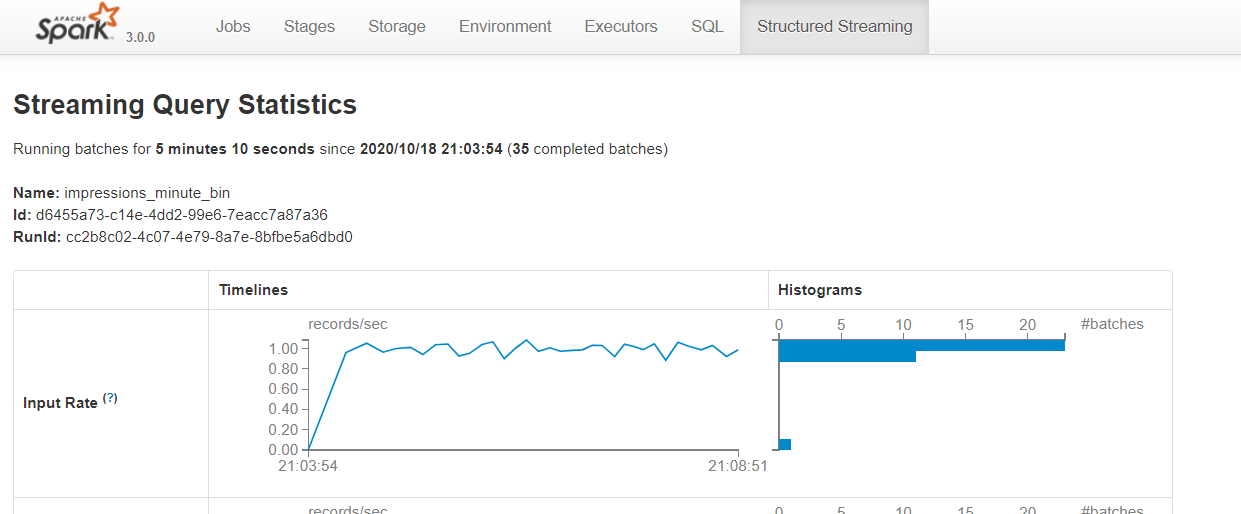

In [ ]:
#Check the Spark UI port using 
#Note that you need to use your IP
spark.sparkContext.uiWebUrl.split(":")[-1]